Training and Predicting
===========================================================

#### Forked From Kaggle - Andy Harless - XGBoost, LightGBM, OLS and NN
Public Score
0.0643646

1. Global Hyper Parameters
---------------------------------------

In [1]:
FUDGE_FACTOR = 1.1200  # Multiply forecasts by this

XGB_WEIGHT = 0.6200
BASELINE_WEIGHT = 0.0100
OLS_WEIGHT = 0.0620
NN_WEIGHT = 0.0800

XGB1_WEIGHT = 0.8000  # Weight of first in combination of two XGB models

BASELINE_PRED = 0.0115   # Baseline based on mean of training data, per Oleg

2. Import Packages
-----------------------------

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,Normalizer
import lightgbm as lgb
import gc
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
import random
import datetime as dt
from collections import OrderedDict
import copy

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.noise import GaussianDropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 9011/11264 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GTX 1080 Ti (0000:06:00.0)


3. Preparation
--------------------------------

In [3]:
test_only=True
clip_norm=(-0.4,0.419)
month_train=range(1,7)
month_test=range(7,10)
prediction_columns=['201607','201608','201609','201707','201708','201709']
apath='E:/Data/zillow'
spath='poly'
prop_lightgbm_path=apath+'/sets/'+spath+'/tree.csv'
prop_xgboost_path=apath+'/sets/'+spath+'/tree.csv'
prop_ols_path=apath+'/sets/'+spath+'/linear.csv'
prop_nn_path=apath+'/sets/'+spath+'/linear.csv'
train_path=apath+'/train.csv'
sample_path=apath+'/bak/sample_submission.csv'

In [4]:
def loader(properties_path,drop_list,outlier_bound=(None,None),parse_date=False):
    print( "\nReading data from disk ...")
    print("   Read properties file ...")
    properties = pd.read_csv(properties_path)
    for c, dtype in zip(properties.columns, properties.dtypes):
        if dtype == np.float64:
            properties[c] = properties[c].astype('float32')
    print("   Read training file ...")
    train = pd.read_csv(train_path, parse_dates=["transactiondate"])
    train_properties = train.merge(properties, how='left', on='parcelid')
    if parse_date:
        train_properties["transactiondate_year"] = train_properties["transactiondate"].dt.year
        train_properties["transactiondate_month"] = train_properties["transactiondate"].dt.month
    if outlier_bound[0] is not None:
        train_properties=train_properties[train_properties.logerror > outlier_bound[0]]
    if outlier_bound[1] is not None:
        train_properties=train_properties[train_properties.logerror < outlier_bound[1]]
    
    cv_train_properties=train_properties.copy()
    cv_train_drop_list=copy.copy(drop_list)
    cv_train_drop_list_all=copy.copy(cv_train_drop_list)
    for dropitem in cv_train_drop_list_all:
        if dropitem not in cv_train_properties.columns.tolist():
            cv_train_drop_list.remove(dropitem)
    y_cv_train = train_properties['logerror']
    x_cv_train = train_properties.drop(cv_train_drop_list, axis=1)
    print(x_cv_train.shape, y_cv_train.shape)
    
    train_properties=train_properties[train_properties['transactiondate'].dt.month.isin(month_train)]
    train_drop_list=copy.copy(drop_list)
    train_drop_list_all=copy.copy(train_drop_list)
    for dropitem in train_drop_list_all:
        if dropitem not in train_properties.columns.tolist():
            train_drop_list.remove(dropitem)
    y_train = train_properties['logerror']
    x_train = train_properties.drop(train_drop_list, axis=1)
    print(x_train.shape, y_train.shape)
    
    print("\nPrepare for prediction ...")
    print("   Read sample file ...")
    sample = pd.read_csv(sample_path)
    sample['parcelid'] = sample['ParcelId']
    print("   ...")
    print("   Merge with property data ...")
    if test_only:
        test_properties = train.merge(properties, how='left', on='parcelid')
        test_properties=test_properties[test_properties['transactiondate'].dt.month.isin(month_test)]
    else:
        test_properties = sample.merge(properties, on='parcelid', how='left')
    parcelid=test_properties['parcelid']
    if parse_date:
        test_properties["transactiondate_year"] = 2016.5
        test_properties["transactiondate_month"] = np.mean(month_test)
    test_drop_list=copy.copy(drop_list)+['ParcelId','201610','201611','201612','201710','201711','201712']
    test_drop_list_all=copy.copy(test_drop_list)
    for dropitem in test_drop_list_all:
        if dropitem not in test_properties.columns.tolist():
            test_drop_list.remove(dropitem)
    x_test=test_properties.drop(test_drop_list, axis=1)
    print(x_test.shape)
    return x_cv_train,y_cv_train,x_train,y_train,x_test,parcelid

In [5]:
def normalize(x_test):
    ssr=StandardScaler()
    ssr.fit(x_test)
    return ssr

In [6]:
def make_catgory(*all_sets):
    for i,sets in enumerate(all_sets):
        for c, dtype in zip(sets.columns, sets.dtypes):
            if c=='parcelid':
                pass
            elif dtype == np.float32:
                pass
            elif dtype == np.float64:
                all_sets[i][c] = sets[c].astype('float32')
            elif dtype ==  np.bool:
                all_sets[i][c] = sets[c].astype("category")
            elif dtype ==  np.int:
                all_sets[i][c] = sets[c].astype("category")
            elif dtype ==  np.int8:
                all_sets[i][c] = sets[c].astype("category")
            elif dtype ==  np.int16:
                all_sets[i][c] = sets[c].astype("category")
            elif dtype ==  np.int32:
                all_sets[i][c] = sets[c].astype("category")
            elif dtype ==  np.int64:
                all_sets[i][c] = sets[c].astype("category")
    return all_sets

In [7]:
valid = pd.read_csv(train_path, parse_dates=["transactiondate"])
y_mask=[]
y_true = valid.logerror[valid['transactiondate'].dt.month.isin(month_test)]
y_date = valid.transactiondate[valid['transactiondate'].dt.month.isin(month_test)]
for yr in [2016,2017]:
    for mt in month_test:
        y_mask.append(np.bitwise_and(y_date.dt.month==mt,y_date.dt.year==yr))
y_mask=np.asarray(y_mask)
y_mask=y_mask.T.astype('int64')
def validate(y_test):
    return np.mean(np.abs(np.sum(y_test*y_mask,1)-y_true))

In [8]:
validate(np.ones_like(y_mask).astype('float32')*BASELINE_PRED)

0.06753257088954569

4. LightGBM
-------------------------

### Process Data for LightGBM

In [16]:
print( "\nProcessing data for LightGBM ..." )

x_cv_train,y_cv_train,x_train,y_train,x_test,parcelid=loader(prop_lightgbm_path,['parcelid', 'logerror', 'transactiondate'])
x_cv_train,x_train,x_test=make_catgory(x_cv_train,x_train,x_test)


Processing data for LightGBM ...

Reading data from disk ...
   Read properties file ...
   Read training file ...
((167888, 148), (167888L,))
((105121, 148), (105121L,))

Prepare for prediction ...
   Read sample file ...
   ...
   Merge with property data ...
(54225, 148)


### Set LightGBM Hyper Parameters

In [10]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'          # or 'mae'
params['sub_feature'] = 0.345    # feature_fraction (small values => use very different submodels)
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

np.random.seed(0)
random.seed(0)

In [11]:
print("\nCross validing LightGBM model ...")

d_cv_train = lgb.Dataset(x_cv_train, label=y_cv_train ,free_raw_data=False)
score=lgb.cv(params, d_cv_train, 430, metrics='mae')

print('Cross Validated Mean Absolute Error :     %s'%(str(score.values()[0][-1])))
print('Cross Validated Mean Absolute Error Std :     %s'%(np.mean(score.values()[1][-1])))
del d_cv_train,score


Cross validing LightGBM model ...


C:\Users\aeloyq\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Cross Validated Mean Absolute Error :     0.0621301388532
Cross Validated Mean Absolute Error Std :     0.00886757245518


### Run LightGBM

In [12]:
print("\nFitting LightGBM model ...")

d_train = lgb.Dataset(x_train, label=y_train ,free_raw_data=False)
clf = lgb.train(params, d_train, 430)


Fitting LightGBM model ...


In [57]:
lightgbm_plot=lgb.plot_tree(clf)

In [58]:
lightgbm_plot_digraph=lgb.create_tree_digraph(clf)

In [60]:
import matplotlib.pyplot as plt

In [70]:
lightgbm_plot.figure.savefig('Results/lightgbm_plot.png')

In [72]:
lightgbm_plot_digraph.save('Results/lightgbm_plot_digraph.png')

'Results/lightgbm_plot_digraph.png'

### LightGBM Prediction

In [13]:
print("\nStart LightGBM prediction ...")

lgb_pred = clf.predict(x_test)

print( "\nUnadjusted LightGBM predictions:" )
print( pd.DataFrame(lgb_pred).head() )


Start LightGBM prediction ...

Unadjusted LightGBM predictions:
          0
0 -0.003978
1  0.010381
2  0.003378
3  0.011961
4  0.006336


### Validate For LightGBM

In [14]:
validate(np.clip(np.tile(lgb_pred[:,None],[1,6]),clip_norm[0],clip_norm[1]))

0.06725869844025725

### Clean for LightGBM

5. XGBoost
-----------------------------

### Process Data For XGBoost

In [18]:
print( "\nProcessing data for XGBoost ...")

x_cv_train,y_cv_train,x_train,y_train,x_test,parcelid=loader(prop_xgboost_path,['parcelid', 'logerror', 'transactiondate'],outlier_bound=clip_norm)
y_mean = np.mean(y_train)
dcvtrain = xgb.DMatrix(x_cv_train, y_cv_train)
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)


Processing data for XGBoost ...

Reading data from disk ...
   Read properties file ...
   Read training file ...
((164477, 148), (164477L,))
((102914, 148), (102914L,))

Prepare for prediction ...
   Read sample file ...
   ...
   Merge with property data ...
(54225, 148)


### Set XGBoost Hyper Parameters

In [19]:
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}
num_boost_rounds = 250

In [20]:
print("\nCross validing XGBoost model ...")

score=xgb.cv(dict(xgb_params, silent=1), dcvtrain, num_boost_round=num_boost_rounds, nfold=5, metrics='mae')

print('Cross Validated Mean Absolute Error :     %s'%(str(score.iloc[-1,0])))
print('Cross Validated Mean Absolute Error Std :     %s'%(str(score.iloc[-1,1])))


Cross validing XGBoost model ...
Cross Validated Mean Absolute Error :     0.0526324
Cross Validated Mean Absolute Error Std :     0.000435497233057


### Run XGBoost

In [21]:
print("\nFitting XGBoost model ...")

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)


Fitting XGBoost model ...


In [26]:
xgboost_1_plot=xgb.plot_tree(model)

In [28]:
xgboost_1_plot_graphviz=xgb.to_graphviz(model)

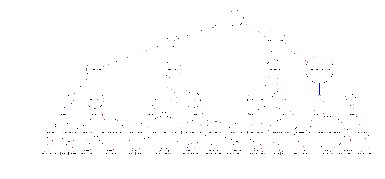

In [78]:
xgboost_1_plot.figure

In [85]:
xgboost_1_plot_graphviz.save('1.pdf')

'1.pdf'

### XGBoost Prediction

In [29]:
print( "\nPredicting with XGBoost ...")

xgb_pred1 = model.predict(dtest)

print( "\nFirst XGBoost predictions:" )
print( pd.DataFrame(xgb_pred1).head() )


Predicting with XGBoost ...

First XGBoost predictions:
          0
0 -0.013637
1  0.003126
2 -0.002773
3  0.006777
4 -0.001322


### Validate For First XGBoost

In [30]:
validate(np.clip(np.tile(xgb_pred1[:,None],[1,6]),clip_norm[0],clip_norm[1]))

0.06697292111501733

### Set XGBoost Hyper Parameters Again

In [31]:
xgb_params = {
    'eta': 0.033,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'base_score': y_mean,
    'silent': 1
}
num_boost_rounds = 150

In [32]:
print("\nCross validing XGBoost model ...")

score=xgb.cv(dict(xgb_params, silent=1), dcvtrain, num_boost_round=num_boost_rounds, nfold=5, metrics='mae')

print('Cross Validated Mean Absolute Error :     %s'%(str(score.iloc[-1,0])))
print('Cross Validated Mean Absolute Error Std :     %s'%(str(score.iloc[-1,1])))


Cross validing XGBoost model ...
Cross Validated Mean Absolute Error :     0.0526452
Cross Validated Mean Absolute Error Std :     0.000440325061744


### Run XGBoost Again

In [33]:
print( "\nTraining XGBoost again ...")

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)


Training XGBoost again ...


In [34]:
xgboost_2_plot=xgb.plot_tree(model)

In [35]:
xgboost_2_plot_graphviz=xgb.to_graphviz(model)

### XGBoost Prediction Again

In [36]:
print( "\nPredicting with XGBoost again ...")

xgb_pred2 = model.predict(dtest)

print( "\nSecond XGBoost predictions:" )
print( pd.DataFrame(xgb_pred2).head() )


Predicting with XGBoost again ...

Second XGBoost predictions:
          0
0 -0.004858
1  0.003548
2 -0.000146
3  0.009720
4  0.002261


### Validate For Second XGBoost

In [37]:
validate(np.clip(np.tile(xgb_pred2[:,None],[1,6]),clip_norm[0],clip_norm[1]))

0.06700912723092256

### Combine Twice XGBoost Predictions

In [38]:
xgb_pred = XGB1_WEIGHT*xgb_pred1 + (1-XGB1_WEIGHT)*xgb_pred2

print( "\nCombined XGBoost predictions:" )
print( pd.DataFrame(xgb_pred).head() )


Combined XGBoost predictions:
          0
0 -0.011881
1  0.003211
2 -0.002248
3  0.007366
4 -0.000605


### Validate For Combined XGBoost

In [39]:
validate(np.clip(np.tile(xgb_pred[:,None],[1,6]),clip_norm[0],clip_norm[1]))

0.06696560300365594

### Clean for XGBoost

In [40]:
del x_cv_train,y_cv_train,x_train,y_train,x_test,parcelid,dcvtrain,dtrain,dtest
gc.collect()

1443

6. Neural Network
----------------------

### Process Data For Neural Network

In [41]:
print( "\n\nProcessing data for Neural Network ...")

x_cv_train,y_cv_train,x_train,y_train,x_test,parcelid=loader(prop_nn_path,['parcelid', 'logerror','transactiondate'],parse_date=True)
len_x=x_train.shape[1]



Processing data for Neural Network ...

Reading data from disk ...
   Read properties file ...
   Read training file ...
((167888, 349), (167888L,))
((105121, 349), (105121L,))

Prepare for prediction ...
   Read sample file ...
   ...
   Merge with property data ...
(54225, 349)


### Set Neural Network

In [42]:
print("\nSetting up neural network model...")
nn = Sequential()
nn.add(Dense(units = 400 , kernel_initializer = 'normal', input_dim = len_x))
nn.add(PReLU())
nn.add(Dropout(.4))
nn.add(Dense(units = 160 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(units = 64 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.5))
nn.add(Dense(units = 26, kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer=Adam(lr=4e-3, decay=1e-4))
plot_model(nn, to_file='nnmodel.png',show_shapes=True)


Setting up neural network model...


In [43]:
kf=KFold(n_splits=5)
loss=[]
for train_index, test_index in kf.split(x_cv_train,y_cv_train):
    nncvhistory=nn.fit(x_cv_train.values[train_index], y_cv_train.values[train_index], batch_size = 4096, epochs = 35, verbose=0,validation_data=(x_cv_train.values[test_index], y_cv_train.values[test_index]))
    loss.append(nncvhistory.history['val_loss'][-1])
    print('   ...')

print('Cross Validated Mean Absolute Error :     %s'%(str(np.mean(loss))))

   ...
   ...
   ...
   ...
   ...
Cross Validated Mean Absolute Error :     0.068905257085


### Run Neural Network

In [44]:
print("\nFitting neural network model...")

nnhistory=nn.fit(np.array(x_train), np.array(y_train), batch_size = 4096, epochs = 70, verbose=0)

print(nnhistory.history['loss'][-1])


Fitting neural network model...
0.0698079611911


### Neural Network Prediction

In [45]:
print("\nPredicting with neural network model...")

preds_dictionary=OrderedDict()
preds_dictionary['parcelid']=parcelid
for i,date in enumerate(prediction_columns):
    x_test_i=x_test.copy()
    x_test_i["transactiondate_year"] = date[:4]
    x_test_i["transactiondate_month"] = date[4:]
    preds_dictionary[date]=nn.predict(x_test_i.values).flatten()
    print "   ..."
    del x_test_i
nn_pred = pd.DataFrame(preds_dictionary)

print( "\nNeural Network predictions:" )
print( pd.DataFrame(nn_pred).head() )


Predicting with neural network model...
   ...
   ...
   ...
   ...
   ...
   ...

Neural Network predictions:
      parcelid    201607    201608    201609    201707    201708    201709
782   14677191  0.006206  0.006206  0.006206  0.006206  0.006206  0.006206
968   11183209  0.006207  0.006207  0.006207  0.006207  0.006207  0.006207
1165  11554091  0.006207  0.006207  0.006207  0.006207  0.006207  0.006207
1351  11742566  0.006208  0.006208  0.006208  0.006208  0.006208  0.006208
1609  14667297  0.006206  0.006206  0.006206  0.006206  0.006206  0.006206


### Validate For NN

In [46]:
validate(np.clip(nn_pred.values[:,1:],clip_norm[0],clip_norm[1]))

0.06746285278703487

### Clean for NN

In [47]:
del preds_dictionary
gc.collect()

4488

7. OLS
-------------------

### Set OLS

In [48]:
np.random.seed(17)
random.seed(17)
gsridge=GridSearchCV(Ridge(),{'alpha':np.e**np.arange(-5,5,0.2)},n_jobs=-1)

In [49]:
print("\nCross validing OLS model ...")

gsridge.fit(x_cv_train, y_cv_train)
gsridge.best_params_['alpha']


Cross validing OLS model ...


121.51041751873579

In [50]:
print("\nCross validing OLS model ...")

reg = Ridge(gsridge.best_params_['alpha'])
score=cross_val_score(reg,x_cv_train, y_cv_train, scoring=make_scorer(mean_absolute_error), cv=5)

print('Cross Validated Mean Absolute Error :     %s'%(str(np.mean(score))))


Cross validing OLS model ...
Cross Validated Mean Absolute Error :     0.0700925928284


### Run OLS

In [51]:
print("\nFitting OLS...")

reg = Ridge(gsridge.best_params_['alpha'])
reg.fit(x_train, y_train)


Fitting OLS...


Ridge(alpha=121.51041751873579, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

### OLS Prediction

In [52]:
print("\nPredicting with OLS model...")

preds_dictionary=OrderedDict()
preds_dictionary['parcelid']=parcelid
for i,date in enumerate(prediction_columns):
    x_test_i=x_test.copy()
    x_test_i["transactiondate_year"] = date[:4]
    x_test_i["transactiondate_month"] = date[4:]
    preds_dictionary[date]=reg.predict(x_test_i.values)
    print "   ..."
    del x_test_i
ols_pred = pd.DataFrame(preds_dictionary)

print( "\nOLS predictions:" )
print( pd.DataFrame(ols_pred).head() )


Predicting with OLS model...
   ...
   ...
   ...
   ...
   ...
   ...

OLS predictions:
      parcelid    201607    201608    201609    201707    201708    201709
782   14677191 -0.020856 -0.022752 -0.024649 -0.016808 -0.018704 -0.020601
968   11183209  0.004274  0.002377  0.000481  0.008322  0.006425  0.004529
1165  11554091 -0.004914 -0.006810 -0.008707 -0.000866 -0.002762 -0.004659
1351  11742566  0.023327  0.021431  0.019534  0.027375  0.025479  0.023582
1609  14667297 -0.010746 -0.012643 -0.014539 -0.006698 -0.008595 -0.010491


### Validate For OLS

In [53]:
validate(np.clip(ols_pred.values[:,1:],clip_norm[0],clip_norm[1]))

0.06822719904974628

### Clean for OLS

In [54]:
del x_train,y_train,x_test,preds_dictionary
gc.collect()

429

8. Combine And Save
----------------------------------

### Combine Predictionsm

In [55]:
print( "\nCombining XGBoost, LightGBM, and baseline predicitons ..." )
lgb_weight = 1 - XGB_WEIGHT - BASELINE_WEIGHT - NN_WEIGHT - OLS_WEIGHT 
pred0 = BASELINE_WEIGHT*BASELINE_PRED
pred0 += lgb_weight*lgb_pred
pred0 += XGB_WEIGHT*xgb_pred

print( "\nCombined XGB/LGB/baseline predictions:" )
print( pd.DataFrame(pred0).head() )

print( "\nCombining with XGB/LGB/NN/OLS/baseline predicitons: ..." )
pred0 =np.tile(pred0[:,None],[1,6]) + NN_WEIGHT*nn_pred.values[:,1:]
pred0 = FUDGE_FACTOR * ( OLS_WEIGHT*ols_pred.values[:,1:] + pred0 )
submission_dict=OrderedDict()
submission_dict['parcelid']=parcelid
for i,date in enumerate(prediction_columns):
    submission_dict[date]=pred0[:,i]
submission=pd.DataFrame(submission_dict)
for c in submission.columns[1:]:
    submission[c]=submission[c].apply(lambda x:float(format(x, '.4f')))

print( "\nCombined XGB/LGB/NN/baseline/OLS predictions:" )
print( submission.head() )


Combining XGBoost, LightGBM, and baseline predicitons ...

Combined XGB/LGB/baseline predictions:
          0
0 -0.008158
1  0.004473
2 -0.000508
3  0.007409
4  0.001184

Combining with XGB/LGB/NN/OLS/baseline predicitons: ...

Combined XGB/LGB/NN/baseline/OLS predictions:
      parcelid  201607  201608  201609  201707  201708  201709
782   14677191 -0.0100 -0.0102 -0.0103 -0.0097 -0.0099 -0.0100
968   11183209  0.0059  0.0057  0.0056  0.0061  0.0060  0.0059
1165  11554091 -0.0004 -0.0005 -0.0006 -0.0001 -0.0002 -0.0003
1351  11742566  0.0105  0.0103  0.0102  0.0108  0.0106  0.0105
1609  14667297  0.0011  0.0010  0.0009  0.0014  0.0013  0.0012


In [56]:
validate(np.clip(submission.values[:,1:],clip_norm[0],clip_norm[1]))

0.06693147954517052